<div style="line-height:1.2;">

<h1 style="color:#FF7C00; margin-bottom: 0.5em;"> UNET with Tensorflow 2 </h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1.5em;"> U-Net model for image segmentation. </h4>

<div style="line-height:1.4; margin-bottom: 1em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    cv2.imread + image.resize + keras.layers + np.expand_dims + tif images + keras Lambda
</div>

<div style="line-height:1.4; margin-top: 1em;">
    <h3 style="color: red; display: inline; margin-right: 0.5em;">Notes:</h3> The 'Electron_Microscopy' folder was not uploaded since it weight 4 Gb.
</div>

</div>

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import cv2
import random
import tifffile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

from skimage import measure, color
from skimage.transform import resize
from skimage.io import imread, imshow

from keras.models import Model
from keras.utils import normalize
from keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [4]:
%%script echo Skipping the load 

tiff_images_training_x = tifffile.imread('./img_folder/Electron_Microscopy/training.tif')
tiff_images_training_y = tifffile.imread('./img_folder/Electron_Microscopy/training_groundtruth.tif')
tiff_images_testing_x = tifffile.imread('./img_folder/Electron_Microscopy/testing.tif')
tiff_images_testing_y = tifffile.imread('./img_folder/Electron_Microscopy/testing_groundtruth.tif')

Skipping the load


In [5]:
%%script echo Skipping resize

resized_images_training_x = []
resized_images_training_y = []
resized_images_testing_x = []
resized_images_testing_y = []

for img in tiff_images_training_x:
    resized_training_x = resize(img, (224, 224))
    normalized_img_training_x = resized_training_x / 255.0
    resized_images_training_x.append(normalized_img_training_x)

for img in tiff_images_training_y:
    resized_training_y = resize(img, (224, 224))
    normalized_img_training_y = resized_training_y / 255.0
    resized_images_training_y.append(normalized_img_training_y)

for img in tiff_images_testing_x:
    resized_testing_x = resize(img, (224, 224))
    normalized_img_testing_x = resized_testing_x / 255.0
    resized_images_testing_x.append(normalized_img_testing_x)

for img in tiff_images_testing_y:
    resized_testing_y = resize(img, (224, 224))
    normalized_img_testing_y = resized_testing_y / 255.0
    resized_images_testing_y.append(normalized_img_testing_y)

preprocessed_images_training_x = np.array(resized_images_training_x)
preprocessed_images_training_y = np.array(resized_images_training_y)
preprocessed_images_testing_x = np.array(resized_images_testing_x)
preprocessed_images_testing_y = np.array(resized_images_testing_y)

Skipping resize


In [5]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 1
SIZE = 256

In [6]:
""" Take all images contained int one tif file.
Dataset is stored in a list
# split : 
    1) .lower() to handle both upper and lower case file extensions (.tif or .TIF).
    2) [-1] to access the last part of the split.

The PIL library allows us to open the multi-page TIFF file and 
use the n_frames property to determine the number of frames (images) in the TIFF file. 
Then each frame is extracted, resized, added to the image_dataset.
"""
image_dataset1 = []  

image_directory = './img_folder/Electron_Microscopy/training/'
images = os.listdir(image_directory)

for i, image_name in enumerate(images):
    if (image_name.split('.')[-1].lower() == 'tif'):  
        image_path = os.path.join(image_directory, image_name)
        with Image.open(image_path) as tif_img:
            num_frames = tif_img.n_frames
            for frame in range(num_frames):
                tif_img.seek(frame)
                image = tif_img.copy()
                image = image.resize((SIZE, SIZE))
                image_dataset1.append(np.array(image))

len(image_dataset1)

165

In [7]:
mask_dataset1 = []  
mask_directory = './img_folder/Electron_Microscopy/training_maks/'
masks = os.listdir(mask_directory)

for i, image_name in enumerate(masks):    
    if (image_name.split('.')[-1].lower() == 'tif'):  # Use [-1] to access the last part of the split
        mask_path = os.path.join(mask_directory, image_name)
        with Image.open(mask_path) as tif_img:
            num_frames = tif_img.n_frames
            for frame in range(num_frames):
                tif_img.seek(frame)
                image = tif_img.copy()
                image = image.resize((SIZE, SIZE))
                mask_dataset1.append(np.array(image))

len(mask_dataset1), mask_dataset1

(165,
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0

In [8]:
""" Create a list containing resized and grayscale versions of the TIFF images.
N.B. 
What if there is a single image for file tif? Get data in arrays! 
"""
image_dataset2 = []
images = os.listdir(image_directory)

# Add a counter and return the enumerate object
for i, image_name in enumerate(images): 
    # Check if the file extension of the image_name is 'tif' (1 => the second element after split with '.' as delimiter)   
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory + image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset2.append(np.array(image))

len(image_dataset2), image_dataset2

(1,
 [array([[115, 124, 131, ..., 166, 180, 187],
         [102, 108, 120, ..., 161, 178, 185],
         [ 98, 110, 122, ..., 150, 176, 189],
         ...,
         [ 99,  99,  98, ..., 114, 162, 156],
         [104, 115, 116, ..., 125, 161, 163],
         [134, 135, 140, ..., 117, 132, 146]], dtype=uint8)])

In [9]:
""" Create a list containing resized and grayscale versions for the masks.
N.B. same as N.B.1  
What if there is a single image for file tif? Get data in arrays!
"""
mask_dataset2 = []  
masks = os.listdir(mask_directory)

for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory + image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset2.append(np.array(image))

len(mask_dataset2), mask_dataset2

(1,
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)])

In [10]:
# Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset1), axis=1),3)

# Mask is not normalized, just rescaled to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset1)),3) /255.

len(mask_dataset), mask_dataset[0][0]

(165,
 array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
    

In [11]:
image_dataset.shape, mask_dataset.shape

((165, 256, 256, 1), (165, 256, 256, 1))

In [12]:
# Split the images in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 0)

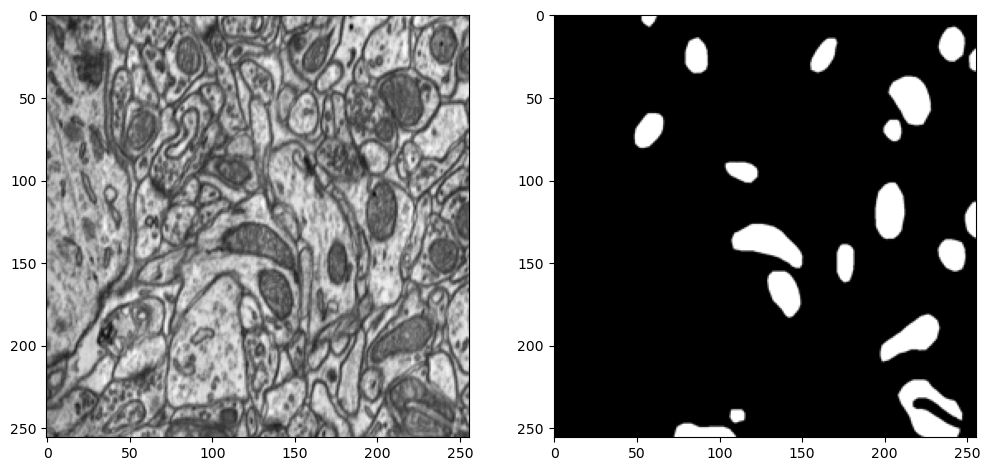

In [13]:
""" Display one image """
image_number = random.randint(0, len(X_train))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

<div style="line-height:0.5">
<h2 style="color:#FF7C00  "> Model description </h2>
</div>
<div style="line-height:1.3">

- The model takes input images of size (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS). <br>
- The contraction path consists of several convolutional blocks with increasing number of filters followed by max pooling. <br>
- Each convolutional block applies two 3x3 convolutional layers with ReLU activation and dropout regularization. <br>
- The expansive path consists of transpose convolutions (upsampling) followed by concatenation with the corresponding <br> contraction path  feature map. <br>
- The concatenated feature maps are processed by convolutional blocks similar to the contraction path, <br> but with the number of filters decreasing. <br>
- The final output is produced by a 1x1 convolutional layer with sigmoid activation. <br>

Compiled with the Adam optimizer and binary cross-entropy loss.
</div>

In [14]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    ######################## Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    ######################### Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [16]:
model = get_model()
######## Train
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# Store the model in Hierarchical Data Format 
model.save('mitochondria_test.hdf5')

2023-08-08 17:18:46.081993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

/home/notto4/anaconda3/envs/MLearning/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Trained for 50 epochs
model_loaded = model.load_weights('mitochondria_test.hdf5') 

### => Load and process the test image - image that needs to be segmented. 

In [18]:
original_tiff_path = './img_folder/Electron_Microscopy/testing.tif'
output_tiff_path = './img_folder/Electron_Microscopy/output_single_image_for_testing.tif'

# Specify the index of the image you want to extract (0-based index)
image_index_to_extract = 3  

###### Open the original multi-page TIFF file
with Image.open(original_tiff_path) as tif_img:
    # Seek to the desired frame (image)
    tif_img.seek(image_index_to_extract)
    # Copy the image to a new variable
    extracted_image = tif_img.copy()
    # Save the extracted image as a new TIFF file
    extracted_image.save(output_tiff_path)

In [19]:
test_img = cv2.imread('./img_folder/Electron_Microscopy/output_single_image_for_testing.tif', 0)

# Resize the test image to (256, 256)
test_img_resized = cv2.resize(test_img, (256, 256))

test_img_norm = np.expand_dims(normalize(np.array(test_img_resized), axis=1), 2)
test_img_norm=test_img_norm[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

In [20]:
# Predict and threshold for values above 0.5 probability
segmented = (model.predict(test_img_input)[0,:,:,0] > 0.05).astype(np.uint8)

1/1 [==============================] - 0s 471ms/step


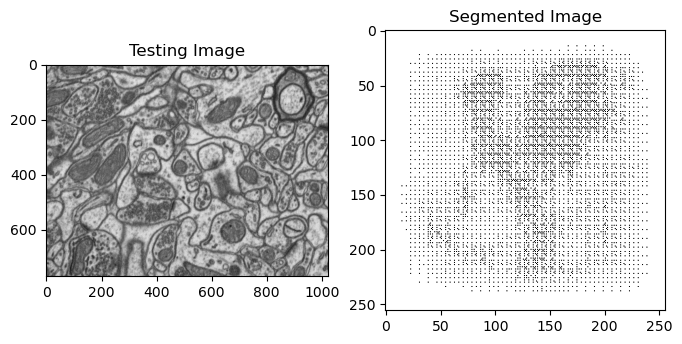

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Segmented Image')
plt.imshow(segmented, cmap='gray')
plt.show()

plt.imsave('./img_folder/Electron_Microscopy/prediction_output_example.jpg', segmented, cmap='gray')

In [22]:
img = cv2.imread('./img_folder/Electron_Microscopy/prediction_output_example.jpg')
img_grey = img[:,:,0]

In [23]:
""" Transform the unet result to binary image using OTSU. ALl thresholded pixels will be set to 255. """
ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [24]:
""" Morphological operations to remove small noise. """
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

<div style="line-height:0.5">
<h3 style="color:#FF7C00  "> Dilatation </h3>
Expands regions in a binary image, making regions of '1' (foreground) larger, which can help in segmenting objects from the background.
</div>

In [25]:
"""" Performe dilation on the opening image using the specified kernel. """
sure_bg = cv2.dilate(opening, kernel, iterations=10)

<div style="line-height:0.4">
<h3 style="color:#FF7C00  "> Distance Transform </h3>
<div style="line-height:1.3">
Compute the distance transform of a binary image using the Euclidean distance metric (L2 distance) and a 5x5 kernel. <br>
The distance of each pixel is calculated in the foreground (white) of the binary image to the nearest background (black) pixel <br>
and stores the distances in the dist_transform image.
</div>
</div>

In [26]:
# Find sure foreground area using distance transform and thresholding
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

In [ ]:
# Threshold the dist transform by starting at 1/2 its max value.
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


In [ ]:
""" Create a marker and label the regions inside. 
N.B
For sure regions, both foreground and background will be labeled with positive numbers.
For unknown regions will be labeled 0. 
"""
ret3, markers = cv2.connectedComponents(sure_fg)

In [ ]:
""" Create markers. 
N.B.
The entire background pixels is given value 0. This means watershed considers this region as unknown.
To solve this issue, add 10 to all labels so that sure background is not 0, but 10.

"""
markers = markers+10
# Mark the region of unknown with zero
markers[unknown==255] = 0
# Look at the 3 distinct regions
#plt.imshow(markers, cmap='gray')   

# Watershed filling 
markers = cv2.watershed(img, markers)
#plt.imshow(markers, cmap='gray')

In [28]:
%%script echo Skipping due to errors
""" Color boundaries in yellow. 
N.B.1
OpenCV should be installed properly, without missing dependencies => sudo apt-get install libgtk2.0-dev pkg-config.
N.B.2
Typical errors: 
"QObject::moveToThread: Current thread (0xe7c6ae0) is not the object's thread (0x8ea8850). Cannot move to target thread (0xe7c6ae0)"
"""
img[markers == -1] = [0,255,255]  
img2 = color.label2rgb(markers, bg_label=0)
# Display the image
cv2.imshow('Overlay on original image', img)
cv2.imshow('Colored Grains', img2)
cv2.waitKey(0)

skipping


In [29]:
""" Compute image properties and return them as a pandas-compatible table.

The table is a dictionary mapping column names to value arrays.
Each column contains either a scalar property, an object property, or an
element in a multidimensional array.
N.B.
**equivalent_diameter_area** : float
    - Label in the labeled input image.
    - Area of the region i.e. number of pixels of the region scaled by pixel-area.
    - Ratio of pixels in the region to pixels of the convex hull imag
    - Diameter of a circle with the same area as the region.
"""
props = measure.regionprops_table(markers, intensity_image=img_grey, 
                properties=['label', 'area', 'equivalent_diameter', 'mean_intensity', 'solidity'])
    
df = pd.DataFrame(props)
# Remove background or other regions that may be counted as objects
df = df[df.mean_intensity > 100]  
print(df.head())

   label     area  equivalent_diameter  mean_intensity  solidity
0     10  42509.0           232.645954      218.471877  0.895832
1     11  21035.0           163.653884      251.425624  0.326043
